# Training UNets

This notebook is part of my (Elvis Sikora) bachelor thesis. 

## Intro

###  A recap: what this work is all about
+ I used OpenFOAM to solve flow cases (2D, Re on the order of 150, polygon shapes)
+ the simulation code was validated for the circular cylinder case against reference values for $C_D$ and the Strouhal number (see the other notebook `Validating the (OpenFOAM) solver.ipynb`)
+ there are already a few thousand cases divided in a train/val/test split. The script to generate them resides in `solve_cases.py`
+ this work can be thought of as a replication of [Guo et al., 2016](https://dl.acm.org/doi/10.1145/2939672.2939738) with some minor changes. 

###  What we're gonna do

Here's what we're gonna do in this notebook:
+ train a UNet in the following task: given a geometry + boundary conditions, predict velocity and pressure fields
+ then we'll use that UNet to predict the drag coefficient $C_D$

There'll be plenty of visualizations so read on to understand how this works.

## From input to output

We'll begin this exploration by simply visualizing the network's input and what the desired output consists of.
First, some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# my code
import train
from unet import UNet, UNetCD, LinearCD

Now, we load the dataset and get its first sample:

In [3]:
dataset = train.Dataset('./data/train')
sample = dataset[0]
sample.keys()

dict_keys(['input', 'output'])

### Seeing the input

Let's take a look at the input:

In [4]:
sample['input'].shape

torch.Size([2, 64, 64])

The input is a (2 x 64 x 64) tensor. The (64 x 64) refers to spatial coordinates to an uniform mesh around the object. This is what each (1 x 64 x 64) slice of the tensor contains:
+ the Reynolds number
+ the x component of the inlet velocity

They're both constant. There's only one Reynolds number per flow. And the freestream velocity is the same everywhere. 

Both of the input channels also contain one more piece of data: the geometry. The arrays contain a 0 in the coordinates occupied by the object.

For these reasons, they look identical when plotted:

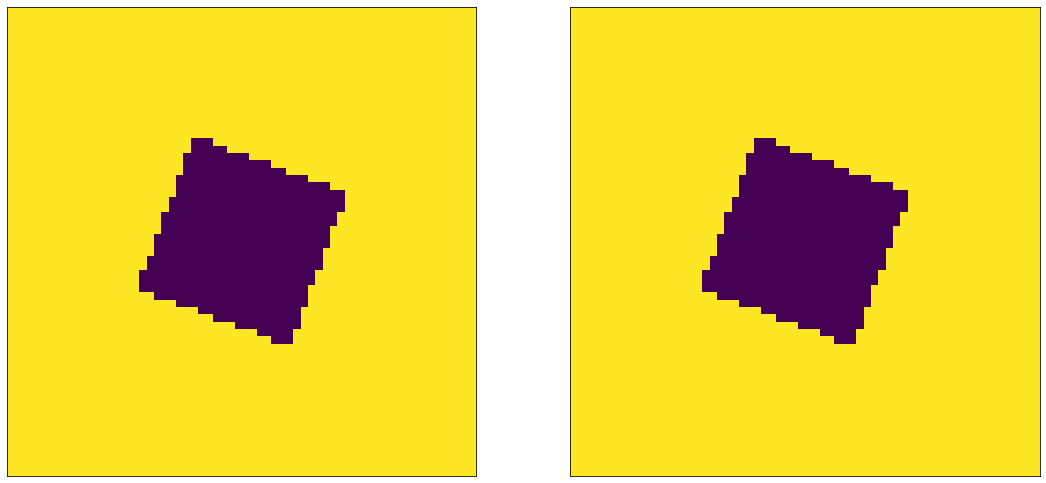

In [5]:
fig, axs = plt.subplots(1, 2)

fig.set_size_inches(18.5, 10.5)


axs[0].imshow(sample['input'][0], norm=plt.Normalize(0, 50))
axs[0].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
axs[1].imshow(sample['input'][1], norm=plt.Normalize(0, 1))
axs[1].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.show()

Making sure that both of the arrays just contain 2 values each (the Reynolds number/freestream x velocity and 0):

In [6]:
all_unique_vals_0 = set(sample['input'][0].flatten().numpy())
all_unique_vals_1 = set(sample['input'][1].flatten().numpy())

print('all unique values in input array:')
print(f'- 0: {all_unique_vals_0}')
print(f'- 1: {all_unique_vals_1}')

all unique values in input array:
- 0: {0.0, 153.29011050196073}
- 1: {0.0, 1.5329011050196073}


### Seeing the output

First, we note the output is (4 x 64 x 64). Here's what the 4 channels refer to:
0. x velocity component
1. y velocity component
2. pressure
3. $C_D$

In [7]:
sample['output'].shape

torch.Size([4, 64, 64])

We plot the 4 channels below: 

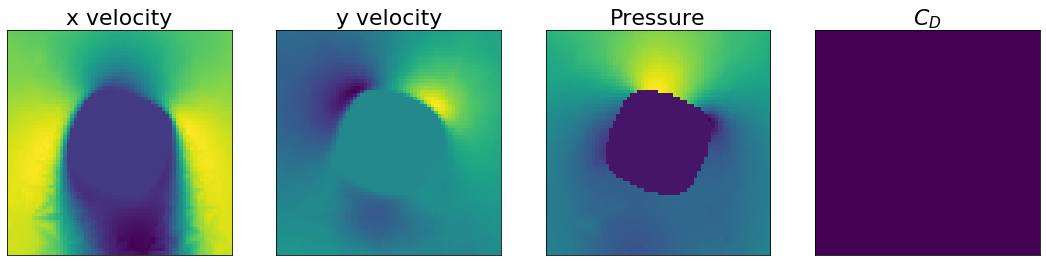

In [8]:
fig, axs = plt.subplots(1, 4)

fig.set_size_inches(18.5, 10.5)
# plt.rcParams.update({'font.size': 22})
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=22)

axs[0].imshow(sample['output'][0])
axs[0].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
axs[0].set_title('x velocity')

axs[1].imshow(sample['output'][1])
axs[1].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
axs[1].set_title('y velocity')

axs[2].imshow(sample['output'][2])
axs[2].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
axs[2].set_title('Pressure')

axs[3].imshow(sample['output'][3])
axs[3].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
axs[3].set_title('$C_D$')

plt.show()

Note that the $C_D$ field is constant, it contains a single value everywhere:

In [9]:
set(sample['output'][3].flatten().numpy())

{1.18005605}

If we used the _mean squared error_ naively to optimize the network, this could bias the training too much to optimize for $C_D$. This isn't a problem though because we actually split training in 2 stages:
1. predicting only the velocity and pressure fields
2. using the trained network, we learn to predict $C_D$

## Training an UNet

For reference, [here](https://arxiv.org/abs/1505.04597)'s the UNet paper and [here](https://github.com/milesial/Pytorch-UNet)'s its PyTorch implementation that I used.

First, if there was a previous run, we might want to load it:

In [10]:
SHOULD_LOAD = True
SHOULD_TRAIN = False

And then load it:

In [41]:
if SHOULD_LOAD:
    tr = train.load_trainer(
        batch_size=256,
        device='cuda',
        sample_type='scaled',
        optimizer=torch.optim.AdamW,
        loss_fn=torch.nn.functional.mse_loss,
        print_every=1,
        save_every=5,
        network_type=UNet,
        num_workers=6,
        end_character='\n')

If not, let's create a new one:

In [12]:
if not SHOULD_LOAD:
    tr = train.create_trainer(num_initializations=50,
                              network_type=UNet,
                              sample_type='scaled',
                              batch_size=256,
                              device='cuda',
                              optimizer=torch.optim.Adam,
                              loss_fn=torch.nn.functional.mse_loss,
                              print_every=1,
                              save_every=5,
                              num_workers=6,
                              end_character='\n')

Let's train the network for some epochs:

In [24]:
if SHOULD_TRAIN:
    tr.epochs(50)


    plt.gcf().set_size_inches(14, 8)
    plt.rcParams.update({'font.size': 22})

    plt.savefig('./checkpoints/loss-plot.png')

an = train.Analyzer(tr, device='cuda')

## Results

First let's compute relative errors:

In [21]:
split = 'test'

In [27]:
print('Relative error')
print('  all channels: ', np.median(an.relative_error(channel='all', split=split, stat='mean')))

x_rel_error = np.mean(an.relative_error(channel='x', split='val', stat='mean'))
y_rel_error = np.mean(an.relative_error(channel='y', split='val', stat='mean'))
p_rel_error = np.mean(an.relative_error(channel='p', split='val', stat='mean'))

print('  x: ', x_rel_error)
print('  y: ', y_rel_error)
print('  p: ', p_rel_error)

Relative error
  all channels:  0.37793213
  x:  0.3004162
  y:  0.43072957
  p:  0.44146186


Now let's visualize the predictions compared to expected fields.

In [28]:
all_mean_rel_errors = an.relative_error(channel='all', i=None, stat='mean', split=split)
best = np.argmin(all_mean_rel_errors)
worst = np.argmax(all_mean_rel_errors)

First, for the worst sample:

worst sample


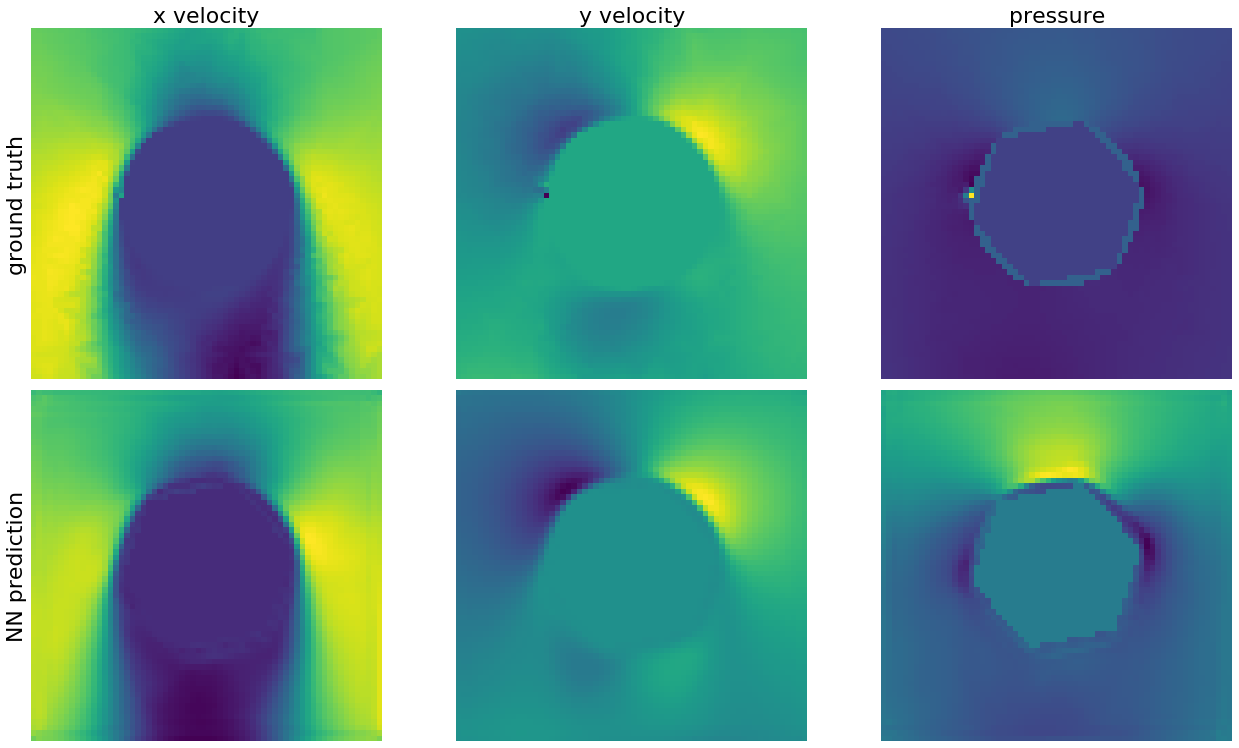

In [29]:
sample = worst

fig, axs = plt.subplots(2, 3)
#fig.suptitle('Best network')
fig.set_size_inches(18.5, 10.5)


    
channel = 'x'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 0])


axs[0, 0].set(ylabel='ground truth')
# make xaxis invisibel
axs[0, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[0,0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[0, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[0,0].patch.set_visible(False)

axs[0, 0].set_title('x velocity')

an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 0])

axs[1, 0].set(ylabel='NN prediction')
# make xaxis invisibel
axs[1, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[1, 0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[1, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[1, 0].patch.set_visible(False)




channel = 'y'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 1])
axs[0, 1].set_title('y velocity')
axs[0, 1].axis('off')
an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 1])
axs[1, 1].axis('off')

channel = 'p'
an.plot_ith_press_exp(sample, axis=axs[0, 2])
axs[0, 2].axis('off')
axs[0, 2].set_title('pressure')
an.plot_ith_press_pred(sample, axis=axs[1, 2])
axs[1, 2].axis('off')

plt.tight_layout()
fig.savefig('./checkpoints/worst.png')
print('worst sample')

Now for a random one:

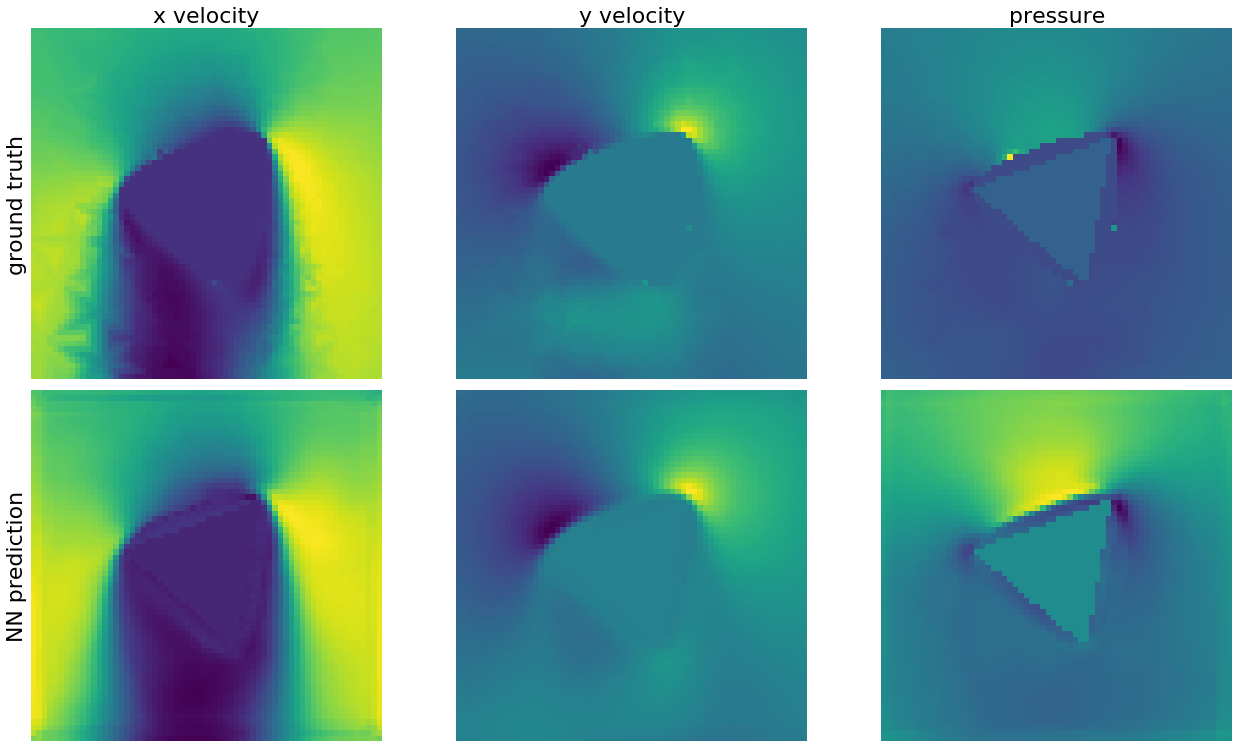

In [33]:
sample = np.random.randint(0, high=an.num_samples('train'))

fig, axs = plt.subplots(2, 3)
#fig.suptitle('Best network')
fig.set_size_inches(18.5, 10.5)
# plt.rcParams.update({'font.size': 22})
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=22)



    
channel = 'x'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 0])


axs[0, 0].set(ylabel='ground truth')
# make xaxis invisibel
axs[0, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[0,0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[0, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[0,0].patch.set_visible(False)

axs[0, 0].set_title('x velocity')

an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 0])

axs[1, 0].set(ylabel='NN prediction')
# make xaxis invisibel
axs[1, 0].xaxis.set_visible(False)
# make spines (the box) invisible
plt.setp(axs[1, 0].spines.values(), visible=False)
# remove ticks and labels for the left axis
axs[1, 0].tick_params(left=False, labelleft=False)
#remove background patch (only needed for non-white background)
axs[1, 0].patch.set_visible(False)




channel = 'y'
an.plot_ith_vel_exp(sample, direction=channel, axis=axs[0, 1])
axs[0, 1].set_title('y velocity')
axs[0, 1].axis('off')
an.plot_ith_vel_pred(sample, direction=channel, axis=axs[1, 1])
axs[1, 1].axis('off')

channel = 'p'
an.plot_ith_press_exp(sample, axis=axs[0, 2])
axs[0, 2].axis('off')
axs[0, 2].set_title('pressure')
an.plot_ith_press_pred(sample, axis=axs[1, 2])
axs[1, 2].axis('off')

plt.tight_layout()
fig.savefig('./checkpoints/random.png')

## Trying the network outside the Reynolds boundary

The network was trained on cases with Reynolds number between 75 and 225.
We'll try it on 2 tiny (10 samples only!) datasets outside of that range:
1. Reynolds between 10 and 75
2. from 225 up to 300

Note that for cylinders in the lower Reynolds range, 
the Strouhal number of the simulations performed by OpenFOAM 
didn't match reference data from the literature that well.
So we're basically training the network to predict what OpenFOAM thinks is the truth,
not the actual real world truth.

In [ ]:
low_re_dataset_dir = Path('./data-out-of-re-bounds/data-re-10-to-75')
high_re_dataset_dir = Path('./data-out-of-re-bounds/data-re-225-to-300')

network = an.network
sample_type = an.training_data.dataset.sample_type

low_re_dataset = train.create_dataloader(base_directory=low_re_dataset_dir,
                                         batch_size=1,
                                         sample_type=sample_type)
high_re_dataset = train.create_dataloader(base_directory=high_re_dataset_dir,
                                          batch_size=1,
                                          sample_type=sample_type)

In [ ]:
def gen_errors_dataframe(trainer, data_gen):
    """Returns DataFrame with errors per channel."""
    assert data_gen.batch_size == 1
    
    sample_results = []
    
    for data_dict in data_gen:
        inp = data_dict['input'].to(torch.float32).to('cuda')
        exp = data_dict['output'].to(torch.float32).to('cuda')

        with torch.no_grad():
            pred = network(inp)
            
        mask = inp[:, 0] == 0
        error_tensor = torch.abs(pred - exp) / torch.max(torch.abs(pred), torch.abs(exp))
        
        n_channels = pred.shape[1]
        assert n_channels == 3
        
        for i in range(n_channels):
            error_tensor[:, i][mask] = 0

        assert error_tensor.shape[0] == 1
        sample_results.append({
                'velocity x': float(torch.mean(error_tensor[0, 0])),
                'velocity y': float(torch.mean(error_tensor[0, 1])),
                'pressure': float(torch.mean(error_tensor[0, 2])),
                'all': float(torch.mean(error_tensor)),
            })
        
    return pd.DataFrame(sample_results)

print('Small Reynolds. Relative errors of the 10 samples with Re < training ones:')
gen_errors_dataframe(tr, low_re_dataset)

In [ ]:
print('Big Reynolds. Relative errors of the 10 samples with Re > training ones:')
gen_errors_dataframe(tr, high_re_dataset)

## Predicting $C_D$

First, we extend our previous network with a linear layer.

In [42]:
extend_network = tr.problem.network

tr = train.create_trainer(
    num_initializations=50,
    network_type=UNet,
    sample_type='scaled',
    batch_size=256,
    device='cuda',
    optimizer=torch.optim.SGD,
    loss_fn=torch.nn.functional.l1_loss,
    optimizer_params={'momentum': 0.8, 'lr': 1e-3},
    print_every=1,
    save_every=100,
    num_workers=6,
    end_character='\n',
    extend_network=extend_network)

Now we train it.

In [44]:
tr.epochs(5)


plt.gcf().set_size_inches(14, 8)
plt.rcParams.update({'font.size': 22})

plt.savefig('./checkpoints/cd-loss-plot.png')
plt.show()

an = train.Analyzer(tr, device='cuda')

Epoch: 16, train loss: 0.11467525362968445, val loss:: 0.10538370907306671 , elapsed time: 0:12:59.968443
Epoch: 17, train loss: 0.12985362112522125, val loss:: 0.12710247933864594 , elapsed time: 0:13:48.150151
Epoch: 18, train loss: 0.11235383152961731, val loss:: 0.10378709435462952 , elapsed time: 0:14:34.777766
Epoch: 19, train loss: 0.10898103564977646, val loss:: 0.10304119437932968 , elapsed time: 0:15:22.423461
Epoch: 20, train loss: 0.10846342146396637, val loss:: 0.09917454421520233 , elapsed time: 0:16:09.719234


<Figure size 1008x576 with 0 Axes>

## Results

Loading the data:

In [ ]:
split = 'test'

cd_exp = []
cd_pred = []

for i in range(an.num_samples(split)):
    exp = float(an.ith_exp(return_type='numpy', split=split, i=i))
    pred = float(an.apply_network(return_type='numpy', split=split, i=i))
    cd_exp.append(exp)
    cd_pred.append(pred)
    
cd_exp = np.array(cd_exp)
cd_pred = np.array(cd_pred)
    
relative_diff = (cd_pred - cd_exp) / cd_exp

cd_exp_mean = np.mean(cd_exp)
cd_pred_mean = np.mean(cd_pred)

cd_exp -= cd_exp_mean
cd_pred -= cd_pred_mean

Let's see the mean relative error:

In [ ]:
mean_rel_err = np.mean(np.abs(relative_diff))
mean_rel_err

Straight line:

In [ ]:
x_min = -100
x_max = 100
x_id = np.arange(x_min, x_max, step=30)
y_id = x_id

Finally, plotting the predicted vs expected value of $C_D$ for all samples:

In [ ]:
# sns.set_style('darkgrid')

plt.gcf().set_size_inches(10.5, 10.5)
# plt.rcParams.update({'font.size': 22})
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=22)

x_bins = 30
sns.regplot(x=cd_pred, y=cd_exp, x_bins=x_bins)
plt.xlabel('$C_D$ predicted by the network')
plt.ylabel('actual $C_D$')
plt.title('Comparing actual vs predicted $C_D$')

plt.plot(x_id, y_id)
lims = -.2, .29
plt.xlim(*lims)
plt.ylim(*lims)


plt.savefig('checkpoints/cd-plot.png')
plt.show()
print(f'relative error {mean_rel_err}')
print(f'for plotting (exclusively) the data was binned into {x_bins} discrete bins')
print(f'data was 0-centered, actual means: pred {cd_pred_mean} vs exp {cd_exp_mean}')